In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
def make_train(DIR="../input/"):
    train=pd.read_csv(DIR+"/train2016_2017_withy.csv",index_col=0)
    labels=train['logerror']
    train=train.drop("logerror",axis=1)
    return (train.values.astype(np.float32),labels.values.astype(np.float32))

In [3]:
train,labels=make_train()
train.shape,labels.shape

((167888, 102), (167888,))

In [4]:
train.nbytes/1024*2. 

133784.0

In [5]:
pd.Series(labels).describe()

count    167888.000000
mean          0.013907
std           0.165696
min          -4.655420
25%          -0.025300
50%           0.006000
75%           0.039200
max           5.262999
dtype: float64

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier

In [7]:
def get_module():
    modulename='xgboost'
    if modulename not in sys.modules:
        sys.path.insert(0, '/home/spark/software/lz/tmp/a/z/third/xgboost/python-package/build/lib/')        
        import xgboost
    if modulename not in sys.modules:
        raise Exception("module not found")
    m=sys.modules[modulename]
    print m.__version__
    assert m.__file__.startswith("/home/spark/software/lz/tmp/a/z/third"), m.__file__
    return  m
        

In [8]:
def shuffle_XY(X,y):
    idx=np.random.permutation(range(len(y)))
    return X[idx],y[idx]
def shuffle_XY2(X,y):
    idx=np.random.choice(range(len(y)),replace=True,size=len(y))
    return X[idx],y[idx]

In [9]:
def make_model(i,trainx,trainy,colsample_bytree=1,max_depth=4,subsample=1,
                                    learning_rate=0.03,min_child_weight=1,objective='reg:l1f0'):
        xgb=get_module()
        models=[]
        X,y=shuffle_XY(trainx,trainy)
        kf = KFold(n_splits=5)
        ymedian=np.median(y)
        scores=[]
        for train_idx, test_idx in kf.split(X):
            X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'mae'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight            
            params['silent'] = 1
            params['base_score'] = ymedian
            params['tree_method']='hist'

            d_train = xgb.DMatrix(X_train, label=y_train)
            d_valid = xgb.DMatrix(X_test, label=y_test)
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            clf = xgb.train(params, d_train, 2000, watchlist, early_stopping_rounds=50, verbose_eval=10)
         
            models.append(clf)
            pred=clf.predict(d_valid,ntree_limit=clf.best_ntree_limit)
            scores.append(mean_absolute_error(y_test,pred))
            print mean_absolute_error(y_train,clf.predict(d_train,ntree_limit=clf.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean loss", np.mean(scores),np.std(scores)
        #return models
        return np.mean(scores),models

In [10]:
def run_once(param,train,labels,test,testlabels):
    colsample_bytree=param["colsample_bytree"]
    max_depth=param["max_depth"]
    subsample=param["subsample"]
    learning_rate=param["learning_rate"]
    min_child_weight=param["min_child_weight"]
    objective=param['objective']
    print param
    s,models=make_model(-1,train,labels,
                   colsample_bytree=colsample_bytree,
                   max_depth=max_depth,
                   subsample=subsample,
                   learning_rate=learning_rate,
                   min_child_weight=min_child_weight,
                  objective=objective
                  )
    print s
    xgb=get_module()
    d_test = xgb.DMatrix(test, label=testlabels)    
    testpred=0
    for m in models:
        testpred = testpred+m.predict(d_test)
    testscore=mean_absolute_error(testlabels, testpred/float(len(models)))
    return s,testscore

In [11]:
import cPickle as pickle
params=pickle.load(open('xg_params.pkl'))

In [12]:
param=params['f0']
param

{'colsample_bytree': 1,
 'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 0.10000000000000001,
 'objective': 'reg:l1f0',
 'subsample': 0.80000000000000004}

In [13]:
#!head -1 ../input/train2016_2017_withy.csv

In [14]:
months=list(set(train[:,1]))
years=list(set(train[:,0]))
months,years

([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0],
 [2016.0, 2017.0])

In [58]:
base_scores=pd.DataFrame([train[:,0],train[:,1],labels]).T

In [59]:
base_scores.columns=['year','month','base']

In [60]:
base_scores=base_scores.groupby(['year','month']).aggregate(
    lambda u: mean_absolute_error(u.values,[np.median(u.values)]*len(u))).reset_index()

In [61]:
base_scores.shape

(21, 3)

In [62]:
base_scores.head()

year  month      base
0  2016.0    1.0  0.071936
1  2016.0    2.0  0.076806
2  2016.0    3.0  0.072027
3  2016.0    4.0  0.069895
4  2016.0    5.0  0.066146

In [15]:
import findspark
findspark.init()

In [16]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
conf = SparkConf()
conf.set('spark.executor.cores',1)
conf.set('spark.executor.instances',1) 
conf.set('spark.speculation','true') 
conf.set('spark.driver.memory','5') 
conf.set('spark.executor.memory','5G') 

#conf.set('spark.cores.max',15)     
conf.setAppName("spark")
conf.setMaster("spark://192.168.0.11:7077")
#conf.setMaster("local")

In [17]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc=spark.sparkContext

In [30]:
data=sc.broadcast((train,labels))

# no month, no year

In [23]:
def make_train_test(X,y,year,month):
    idx=(X[:,0]==year) & (X[:,1]==month)
    print np.sum(idx),np.sum(~idx)
    a,b,c,d=X[~idx],y[~idx],X[idx],y[idx]
    a,b,c,d=a[:,2:],b,c[:,2:],d
    print a.shape,b.shape,c.shape,d.shape
    return a,b,c,d

In [26]:
year_month=[(u,v) for u in years for v in months]
len(year_month)

In [36]:
def run_once_2(year,month):
    train,labels,test,testlabels = make_train_test(data.value[0],data.value[1],year,month)
    if len(test)==0:
        return year,month,np.nan,np.nan
    else:
        a,b=run_once(param,train,labels,test,testlabels)
        return year,month,a,b

In [37]:
%time results=sc.parallelize(year_month,len(year_month)).map(lambda u: run_once_2(u[0],u[1])).collect()

CPU times: user 63.5 ms, sys: 4.71 ms, total: 68.2 ms
Wall time: 5min 17s


In [74]:
df=pd.DataFrame(results,columns=['year','month','valid_score','test_score'])

In [77]:
df=pd.merge(df,base_scores,on=['year','month'],how="inner")

In [78]:
df['gain']=df['base']-df['test_score']

In [81]:
df['ym']=df[['year','month']].apply(lambda u: "-".join(u.values.astype(np.int).astype(np.str)),axis=1)

In [82]:
df

year  month  valid_score  test_score      base      gain       ym
0   2016.0    1.0     0.067900    0.070819  0.071936  0.001117   2016-1
1   2016.0    2.0     0.067706    0.075901  0.076806  0.000905   2016-2
2   2016.0    3.0     0.067847    0.071175  0.072027  0.000852   2016-3
3   2016.0    4.0     0.067960    0.068952  0.069895  0.000943   2016-4
4   2016.0    5.0     0.068201    0.065177  0.066146  0.000969   2016-5
5   2016.0    6.0     0.068209    0.065270  0.066006  0.000735   2016-6
6   2016.0    7.0     0.068296    0.063705  0.064810  0.001105   2016-7
7   2016.0    8.0     0.068262    0.064640  0.065831  0.001191   2016-8
8   2016.0    9.0     0.068178    0.065401  0.066308  0.000907   2016-9
9   2016.0   10.0     0.068174    0.062741  0.063605  0.000865  2016-10
10  2016.0   11.0     0.068084    0.061697  0.062636  0.000939  2016-11
11  2016.0   12.0     0.067956    0.074321  0.074896  0.000575  2016-12
12  2017.0    1.0     0.067808    0.073047  0.073552  0.000504   2017-1
13  2017.0    2.0     0.067866    0.071146  0.071881  0.000736   2017-2
14  2017.0    3.0     0.068011    0.068288  0.068859  0.000571   2017-3
15  2017.0    4.0     0.067994    0.068312  0.068874  0.000562   2017-4
16  2017.0    5.0     0.068089    0.067197  0.067740  0.000542   2017-5
17  2017.0    6.0     0.068012    0.068338  0.068944  0.000607   2017-6
18  2017.0    7.0     0.068378    0.061983  0.062908  0.000925   2017-7
19  2017.0    8.0     0.067668    0.073335  0.073913  0.000578   2017-8
20  2017.0    9.0     0.067899    0.072804  0.073318  0.000514   2017-9

In [83]:
df.gain.mean()

0.0007924311351101996

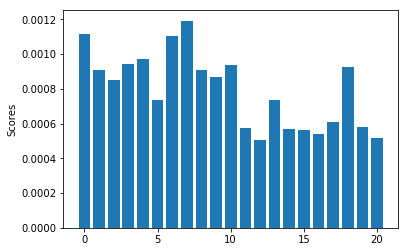

In [100]:
fig, ax = plt.subplots()
ax.bar(range(len(df)),df['gain'])
ax.set_ylabel('Scores')
ax.set_xticklabels=tuple(df['ym'].values)

# no year, has month

In [101]:
def make_train_test(X,y,year,month):
    idx=(X[:,0]==year) & (X[:,1]==month)
    print np.sum(idx),np.sum(~idx)
    a,b,c,d=X[~idx],y[~idx],X[idx],y[idx]
    a,b,c,d=a[:,1:],b,c[:,1:],d
    print a.shape,b.shape,c.shape,d.shape
    return a,b,c,d

In [102]:
year_month=[(u,v) for u in years for v in months]
len(year_month)

24

In [103]:
def run_once_2(year,month):
    train,labels,test,testlabels = make_train_test(data.value[0],data.value[1],year,month)
    if len(test)==0:
        return year,month,np.nan,np.nan
    else:
        a,b=run_once(param,train,labels,test,testlabels)
        return year,month,a,b

In [104]:
%time results=sc.parallelize(year_month,len(year_month)).map(lambda u: run_once_2(u[0],u[1])).collect()

CPU times: user 51.2 ms, sys: 5.28 ms, total: 56.5 ms
Wall time: 6min 1s


In [105]:
df=pd.DataFrame(results,columns=['year','month','valid_score','test_score'])

In [106]:
df=pd.merge(df,base_scores,on=['year','month'],how="inner")

In [107]:
df['gain']=df['base']-df['test_score']

In [108]:
df['ym']=df[['year','month']].apply(lambda u: "-".join(u.values.astype(np.int).astype(np.str)),axis=1)

In [109]:
df

year  month  valid_score  test_score      base      gain       ym
0   2016.0    1.0     0.067820    0.070756  0.071936  0.001181   2016-1
1   2016.0    2.0     0.067612    0.075932  0.076806  0.000874   2016-2
2   2016.0    3.0     0.067777    0.071002  0.072027  0.001025   2016-3
3   2016.0    4.0     0.067887    0.068891  0.069895  0.001004   2016-4
4   2016.0    5.0     0.068100    0.065132  0.066146  0.001014   2016-5
5   2016.0    6.0     0.068120    0.065244  0.066006  0.000762   2016-6
6   2016.0    7.0     0.068213    0.063745  0.064810  0.001065   2016-7
7   2016.0    8.0     0.068167    0.064825  0.065831  0.001006   2016-8
8   2016.0    9.0     0.068096    0.065174  0.066308  0.001134   2016-9
9   2016.0   10.0     0.068092    0.062401  0.063605  0.001204  2016-10
10  2016.0   11.0     0.068006    0.061490  0.062636  0.001146  2016-11
11  2016.0   12.0     0.067882    0.073995  0.074896  0.000901  2016-12
12  2017.0    1.0     0.067718    0.072863  0.073552  0.000688   2017-1
13  2017.0    2.0     0.067791    0.071203  0.071881  0.000678   2017-2
14  2017.0    3.0     0.067925    0.068171  0.068859  0.000688   2017-3
15  2017.0    4.0     0.067899    0.068075  0.068874  0.000799   2017-4
16  2017.0    5.0     0.067974    0.067098  0.067740  0.000641   2017-5
17  2017.0    6.0     0.067901    0.068330  0.068944  0.000614   2017-6
18  2017.0    7.0     0.068293    0.062027  0.062908  0.000880   2017-7
19  2017.0    8.0     0.067599    0.073330  0.073913  0.000583   2017-8
20  2017.0    9.0     0.067772    0.072582  0.073318  0.000736   2017-9

In [110]:
df.gain.mean()

0.00088685943880606

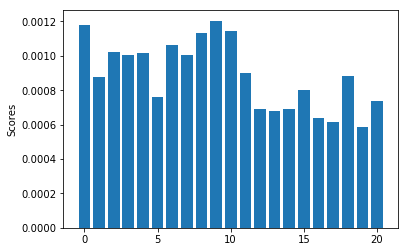

In [111]:
fig, ax = plt.subplots()
ax.bar(range(len(df)),df['gain'])
ax.set_ylabel('Scores')
ax.set_xticklabels=tuple(df['ym'].values)

# no month, has year

In [120]:
def make_train_test(X,y,year,month):
    idx=(X[:,0]==year) & (X[:,1]==month)
    print np.sum(idx),np.sum(~idx)
    a,b,c,d=X[~idx],y[~idx],X[idx],y[idx]
    colidx=[u for u in range(X.shape[1]) if u!=1]
    a,b,c,d=a[:,colidx],b,c[:,colidx],d
    print a.shape,b.shape,c.shape,d.shape
    return a,b,c,d

In [121]:
#a,_,_,_=make_train_test(train,labels,2017,2)

In [122]:
year_month=[(u,v) for u in years for v in months]
len(year_month)

24

In [123]:
def run_once_2(year,month):
    train,labels,test,testlabels = make_train_test(data.value[0],data.value[1],year,month)
    if len(test)==0:
        return year,month,np.nan,np.nan
    else:
        a,b=run_once(param,train,labels,test,testlabels)
        return year,month,a,b

In [124]:
%time results=sc.parallelize(year_month,len(year_month)).map(lambda u: run_once_2(u[0],u[1])).collect()

CPU times: user 55.2 ms, sys: 6.48 ms, total: 61.7 ms
Wall time: 6min 15s


In [125]:
df=pd.DataFrame(results,columns=['year','month','valid_score','test_score'])

In [126]:
df=pd.merge(df,base_scores,on=['year','month'],how="inner")

In [127]:
df['gain']=df['base']-df['test_score']

In [128]:
df['ym']=df[['year','month']].apply(lambda u: "-".join(u.values.astype(np.int).astype(np.str)),axis=1)

In [129]:
df

year  month  valid_score  test_score      base      gain       ym
0   2016.0    1.0     0.067910    0.070796  0.071936  0.001141   2016-1
1   2016.0    2.0     0.067710    0.075941  0.076806  0.000865   2016-2
2   2016.0    3.0     0.067843    0.071160  0.072027  0.000867   2016-3
3   2016.0    4.0     0.067966    0.068982  0.069895  0.000913   2016-4
4   2016.0    5.0     0.068208    0.065222  0.066146  0.000924   2016-5
5   2016.0    6.0     0.068219    0.065282  0.066006  0.000724   2016-6
6   2016.0    7.0     0.068315    0.063725  0.064810  0.001085   2016-7
7   2016.0    8.0     0.068257    0.064624  0.065831  0.001207   2016-8
8   2016.0    9.0     0.068189    0.065420  0.066308  0.000888   2016-9
9   2016.0   10.0     0.068165    0.062717  0.063605  0.000889  2016-10
10  2016.0   11.0     0.068072    0.061647  0.062636  0.000989  2016-11
11  2016.0   12.0     0.067944    0.074214  0.074896  0.000682  2016-12
12  2017.0    1.0     0.067795    0.073052  0.073552  0.000499   2017-1
13  2017.0    2.0     0.067876    0.071199  0.071881  0.000682   2017-2
14  2017.0    3.0     0.067999    0.068316  0.068859  0.000544   2017-3
15  2017.0    4.0     0.067989    0.068296  0.068874  0.000578   2017-4
16  2017.0    5.0     0.068062    0.067180  0.067740  0.000559   2017-5
17  2017.0    6.0     0.068011    0.068351  0.068944  0.000593   2017-6
18  2017.0    7.0     0.068390    0.061971  0.062908  0.000936   2017-7
19  2017.0    8.0     0.067679    0.073370  0.073913  0.000544   2017-8
20  2017.0    9.0     0.067853    0.072803  0.073318  0.000515   2017-9

In [130]:
df.gain.mean()

0.0007915670451557326

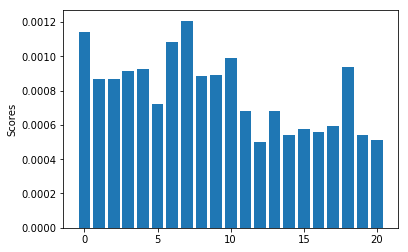

In [131]:
fig, ax = plt.subplots()
ax.bar(range(len(df)),df['gain'])
ax.set_ylabel('Scores')
ax.set_xticklabels=tuple(df['ym'].values)

# has month, has year

In [132]:
def make_train_test(X,y,year,month):
    idx=(X[:,0]==year) & (X[:,1]==month)
    print np.sum(idx),np.sum(~idx)
    a,b,c,d=X[~idx],y[~idx],X[idx],y[idx]
    #colidx=[u for u in range(X.shape[1]) if u!=1]
    #a,b,c,d=a[:,colidx],b,c[:,colidx],d
    print a.shape,b.shape,c.shape,d.shape
    return a,b,c,d

In [134]:
#a,_,_,_=make_train_test(train,labels,2017,2);print a.shape

In [135]:
year_month=[(u,v) for u in years for v in months]
len(year_month)

24

In [136]:
def run_once_2(year,month):
    train,labels,test,testlabels = make_train_test(data.value[0],data.value[1],year,month)
    if len(test)==0:
        return year,month,np.nan,np.nan
    else:
        a,b=run_once(param,train,labels,test,testlabels)
        return year,month,a,b

In [137]:
%time results=sc.parallelize(year_month,len(year_month)).map(lambda u: run_once_2(u[0],u[1])).collect()

CPU times: user 35.6 ms, sys: 4.9 ms, total: 40.5 ms
Wall time: 3min 28s


In [138]:
df=pd.DataFrame(results,columns=['year','month','valid_score','test_score'])

In [139]:
df=pd.merge(df,base_scores,on=['year','month'],how="inner")

In [140]:
df['gain']=df['base']-df['test_score']

In [141]:
df['ym']=df[['year','month']].apply(lambda u: "-".join(u.values.astype(np.int).astype(np.str)),axis=1)

In [142]:
df

year  month  valid_score  test_score      base      gain       ym
0   2016.0    1.0     0.067805    0.070693  0.071936  0.001243   2016-1
1   2016.0    2.0     0.067597    0.075906  0.076806  0.000900   2016-2
2   2016.0    3.0     0.067763    0.070997  0.072027  0.001030   2016-3
3   2016.0    4.0     0.067872    0.068858  0.069895  0.001037   2016-4
4   2016.0    5.0     0.068107    0.065107  0.066146  0.001039   2016-5
5   2016.0    6.0     0.068126    0.065246  0.066006  0.000760   2016-6
6   2016.0    7.0     0.068216    0.063734  0.064810  0.001076   2016-7
7   2016.0    8.0     0.068158    0.064826  0.065831  0.001005   2016-8
8   2016.0    9.0     0.068106    0.065163  0.066308  0.001145   2016-9
9   2016.0   10.0     0.068065    0.062417  0.063605  0.001189  2016-10
10  2016.0   11.0     0.067997    0.061501  0.062636  0.001135  2016-11
11  2016.0   12.0     0.067855    0.074022  0.074896  0.000874  2016-12
12  2017.0    1.0     0.067714    0.072839  0.073552  0.000713   2017-1
13  2017.0    2.0     0.067804    0.071232  0.071881  0.000650   2017-2
14  2017.0    3.0     0.067912    0.068144  0.068859  0.000715   2017-3
15  2017.0    4.0     0.067888    0.068093  0.068874  0.000781   2017-4
16  2017.0    5.0     0.067980    0.067129  0.067740  0.000610   2017-5
17  2017.0    6.0     0.067898    0.068312  0.068944  0.000632   2017-6
18  2017.0    7.0     0.068285    0.062023  0.062908  0.000884   2017-7
19  2017.0    8.0     0.067621    0.073290  0.073913  0.000623   2017-8
20  2017.0    9.0     0.067781    0.072527  0.073318  0.000791   2017-9

In [143]:
df.gain.mean()

0.0008967939010581774

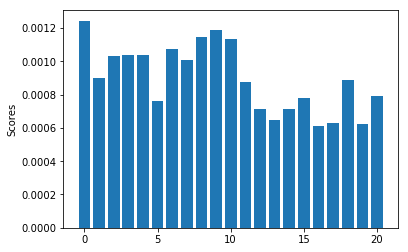

In [144]:
fig, ax = plt.subplots()
ax.bar(range(len(df)),df['gain'])
ax.set_ylabel('Scores')
ax.set_xticklabels=tuple(df['ym'].values)

# has month, has year, only 2017 data

In [213]:
def make_train_test(X,y,year,month):
    idx=X[:,0]==2017
    X=X[idx]
    y=y[idx]    
    idx=(X[:,0]==year) & (X[:,1]==month)
    print np.sum(idx),np.sum(~idx)
    a,b,c,d=X[~idx],y[~idx],X[idx],y[idx]
    #colidx=[u for u in range(X.shape[1]) if u!=1]
    #a,b,c,d=a[:,colidx],b,c[:,colidx],d
    print a.shape,b.shape,c.shape,d.shape
    return a,b,c,d

In [214]:
#a,_,_,_=make_train_test(train,labels,2017,2);print a.shape

In [215]:
year_month=[(u,v) for u in years for v in months if u ==2017]
len(year_month)

12

In [216]:
def run_once_2(year,month):
    train,labels,test,testlabels = make_train_test(data.value[0],data.value[1],year,month)
    if len(test)==0:
        return year,month,np.nan,np.nan
    else:
        a,b=run_once(param,train,labels,test,testlabels)
        return year,month,a,b

In [217]:
%time results=sc.parallelize(year_month,len(year_month)).map(lambda u: run_once_2(u[0],u[1])).collect()

CPU times: user 14.3 ms, sys: 3.34 ms, total: 17.6 ms
Wall time: 56.5 s


In [218]:
df=pd.DataFrame(results,columns=['year','month','valid_score','test_score'])

In [219]:
df=pd.merge(df,base_scores,on=['year','month'],how="inner")

In [220]:
df['gain']=df['base']-df['test_score']

In [221]:
df['ym']=df[['year','month']].apply(lambda u: "-".join(u.values.astype(np.int).astype(np.str)),axis=1)

In [222]:
df

year  month  valid_score  test_score      base      gain      ym
0  2017.0    1.0     0.068610    0.073223  0.073552  0.000329  2017-1
1  2017.0    2.0     0.068849    0.071398  0.071881  0.000483  2017-2
2  2017.0    3.0     0.069126    0.068279  0.068859  0.000580  2017-3
3  2017.0    4.0     0.069174    0.068114  0.068874  0.000760  2017-4
4  2017.0    5.0     0.069334    0.067148  0.067740  0.000591  2017-5
5  2017.0    6.0     0.069156    0.068429  0.068944  0.000515  2017-6
6  2017.0    7.0     0.070013    0.062205  0.062908  0.000702  2017-7
7  2017.0    8.0     0.068403    0.073254  0.073913  0.000660  2017-8
8  2017.0    9.0     0.068806    0.072605  0.073318  0.000713  2017-9

In [223]:
df.gain.mean()

0.0005925688289419923

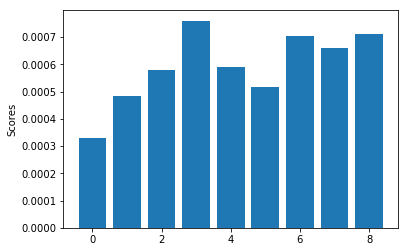

In [224]:
fig, ax = plt.subplots()
ax.bar(range(len(df)),df['gain'])
ax.set_ylabel('Scores')
ax.set_xticklabels=tuple(df['ym'].values)

# has month, has year, only 2016 data

In [200]:
def make_train_test(X,y,year,month):
    idx=X[:,0]==2016
    X=X[idx]
    y=y[idx]
    idx=(X[:,0]==year) & (X[:,1]==month)
    print np.sum(idx),np.sum(~idx)
    a,b,c,d=X[~idx],y[~idx],X[idx],y[idx]
    #colidx=[u for u in range(X.shape[1]) if u!=1]
    #a,b,c,d=a[:,colidx],b,c[:,colidx],d
    print a.shape,b.shape,c.shape,d.shape
    return a,b,c,d

In [202]:
a,_,_,_=make_train_test(train,labels,2016,2);print a.shape

6333 83942
(83942, 102) (83942,) (6333, 102) (6333,)
(83942, 102)


In [203]:
year_month=[(u,v) for u in years for v in months if u ==2016]
len(year_month)

12

In [204]:
def run_once_2(year,month):
    train,labels,test,testlabels = make_train_test(data.value[0],data.value[1],year,month)
    if len(test)==0:
        return year,month,np.nan,np.nan
    else:
        a,b=run_once(param,train,labels,test,testlabels)
        return year,month,a,b

In [205]:
%time results=sc.parallelize(year_month,len(year_month)).map(lambda u: run_once_2(u[0],u[1])).collect()

CPU times: user 34.5 ms, sys: 4.07 ms, total: 38.6 ms
Wall time: 3min 19s


In [206]:
df=pd.DataFrame(results,columns=['year','month','valid_score','test_score'])

In [207]:
df=pd.merge(df,base_scores,on=['year','month'],how="inner")

In [208]:
df['gain']=df['base']-df['test_score']

In [209]:
df['ym']=df[['year','month']].apply(lambda u: "-".join(u.values.astype(np.int).astype(np.str)),axis=1)

In [210]:
df

year  month  valid_score  test_score      base      gain       ym
0   2016.0    1.0     0.066843    0.070728  0.071936  0.001208   2016-1
1   2016.0    2.0     0.066477    0.076231  0.076806  0.000575   2016-2
2   2016.0    3.0     0.066713    0.071067  0.072027  0.000960   2016-3
3   2016.0    4.0     0.066973    0.068911  0.069895  0.000984   2016-4
4   2016.0    5.0     0.067404    0.065191  0.066146  0.000955   2016-5
5   2016.0    6.0     0.067409    0.065317  0.066006  0.000689   2016-6
6   2016.0    7.0     0.067545    0.063755  0.064810  0.001055   2016-7
7   2016.0    8.0     0.067481    0.064858  0.065831  0.000973   2016-8
8   2016.0    9.0     0.067379    0.065257  0.066308  0.001051   2016-9
9   2016.0   10.0     0.067419    0.062463  0.063605  0.001142  2016-10
10  2016.0   11.0     0.067237    0.061553  0.062636  0.001083  2016-11
11  2016.0   12.0     0.067017    0.074003  0.074896  0.000893  2016-12

In [211]:
df.gain.mean()

0.0009638724602957933

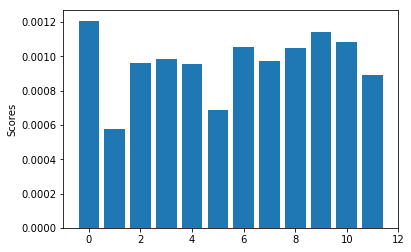

In [212]:
fig, ax = plt.subplots()
ax.bar(range(len(df)),df['gain'])
ax.set_ylabel('Scores')
ax.set_xticklabels=tuple(df['ym'].values)